# Python Operators
This example shows you how to run custom Python code by using the family of DALI `PythonFunction` operators to prototype new augmentations or debug the pipeline.
The idea behind these operators is to help you to execute the Python code that operates on DALI's tensors' data in the pipeline execution. 

## Defining an Operation
The operator that we will use first is `PythonFunction`, which wraps a regular Python function and runs it in a DALI Pipeline.

We define this function as an example and call it `edit_images`.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np

def edit_images(image1, image2):
    assert image1.shape == image2.shape
    h, w, c = image1.shape
    y, x = np.ogrid[0:h, 0:w]
    mask = (x - w / 2) ** 2 + (y - h / 2) ** 2 > h * w / 9
    result1 = np.copy(image1)
    result1[mask] = image2[mask]
    result2 = np.copy(image2)
    result2[mask] = image1[mask]
    return result1, result2

* In this case, it takes two arrays as inputs and returns two outputs. 
* The code creates a circular mask and uses it to swap those circular parts between two inputs. 

`PythonFunction` uses NumPy arrays as the data format for the CPU, and [CuPy](https://cupy.chainer.org/) arrays for GPU. 

**Note:** Both input images are copied, because the input data should not be modified.

## Defining a Pipeline
To see the operator in action, we implement a simple data pipeline:

1. Create a Pipeline instance with `exec_async` and `exec_pipelined` parameters set to `False`.

2. Load, decode and resize the images to common size.

3. Wrap the `edit_images` by passing it as `function` parameter to `dali.fn.python_function`.

4. In addition to the function, we pass the number of outputs as a parameter.

5. We invoke the `python_function` like any other DALI operator - the inputs will be passed to `edit_images` for processing.

In [2]:
image_dir = '../data/images'
batch_size = 4

python_function_pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0,
                                exec_async=False, exec_pipelined=False, seed=99)

with python_function_pipe:
    input1, _ = fn.readers.file(file_root=image_dir, random_shuffle=True)
    input2, _ = fn.readers.file(file_root=image_dir, random_shuffle=True)
    im1, im2 = fn.decoders.image([input1, input2], device='cpu', output_type=types.RGB)
    res1, res2 = fn.resize([im1, im2], resize_x=300, resize_y=300)
    out1, out2 = fn.python_function(res1, res2, function=edit_images, num_outputs=2)
    python_function_pipe.set_outputs(out1, out2)

## Running the Pipeline and Visualizing the Results
To see the results, run the pipeline.

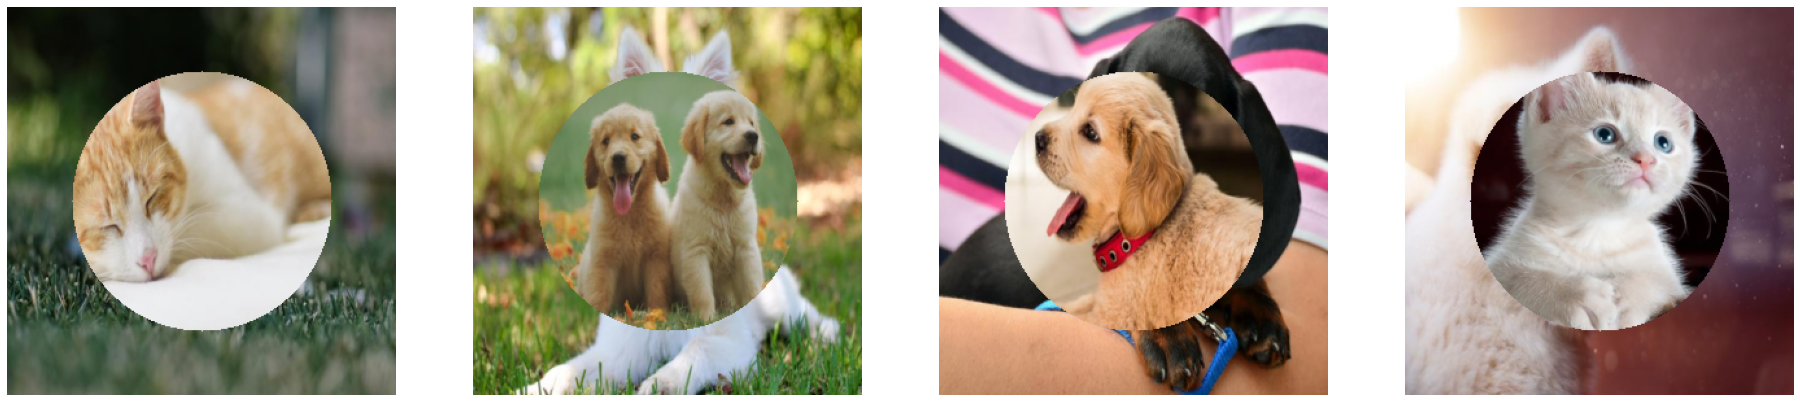

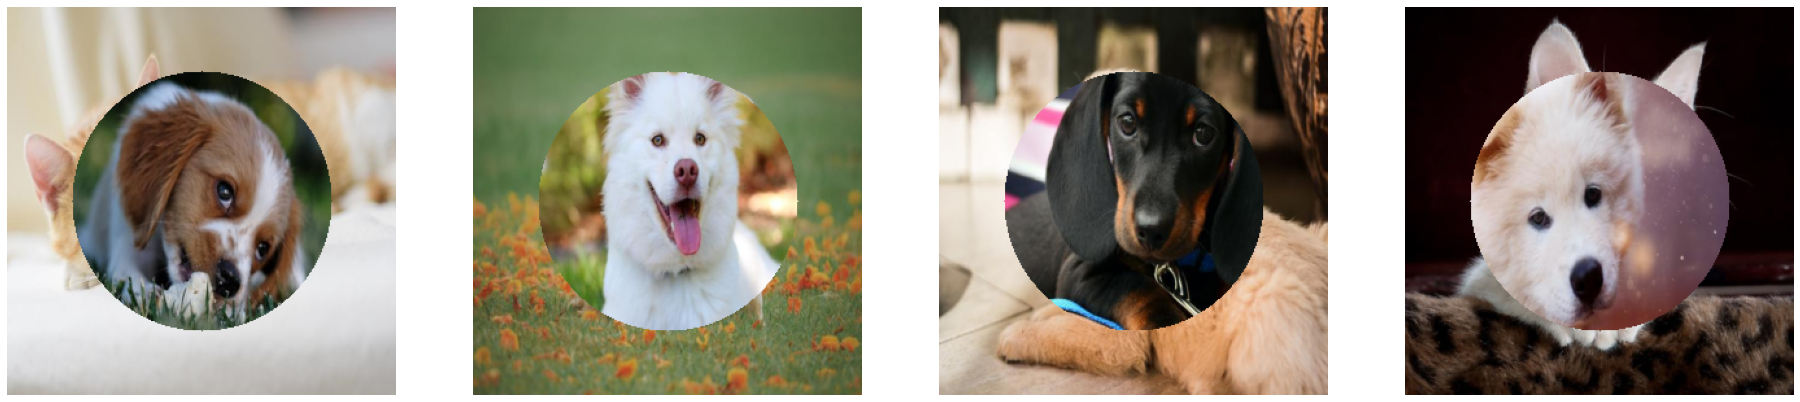

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))
        
        
python_function_pipe.build()
ims1, ims2 = python_function_pipe.run()

show_images(ims1)
show_images(ims2)

## Variety of Python Operators
In DALI, `PythonFunction` comes in different flavors. The basic idea remains, but the data format on which the implementation operates differs in the following ways: 

* `PythonFunction` - works on arrays.
* `TorchPythonFunction` - works on PyTorch tensors.
* `DLTensorPythonFunction` - works on [DLPack](https://github.com/dmlc/dlpack) tensors.

The most universal operator is `DLTensorPythonFunction`. DLPack is an open standard for tensor storage and many frameworks and libraries implement conversion methods to and from DLPack tensors. Internally it is used to implement all the other kinds of Python operators.

### TorchPythonFunction and DLTensorPythonFunction
The example provides information about using the PyTorch functions in the DALI pipeline. The ideal way to use those functions is to use the `TorchPythonFunction` operator, but we will also use the `DLTensorPythonFunction` to show how you can work with `DLPack` tensors.

We use the torchvision `RandomPerspective` transform in the `perspective` function, and we will wrap it in the `TorchPythonFunction`. 

The `dlpack_manipulation` function shows you how to handle DLPack data:

1. The input batch is converted to a list of PyTorch tensors.

2. Converted input is processed. 

3. The output is converted back to DLPack tensors. 

Every Python operator has the `batch_processing` parameter. This parameter determines whether the implementation function gets the whole batch as a list of tensors or whether it will be called per sample. Due to historical reasons, for `DLTensorPythonFunction`, this parameter is set to *True* by default. We can look at `dlpack_manipulation` to see how to work with this kind of input.

In [4]:
import nvidia.dali.plugin.pytorch as dalitorch
import torch
import torch.utils.dlpack as torch_dlpack
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToPILImage(),
                              transforms.RandomPerspective(p=1.),
                              transforms.ToTensor()])
def perspective(t):
    return transform(t).transpose(2, 0).transpose(0, 1)

def dlpack_manipulation(dlpacks):
    tensors = [torch_dlpack.from_dlpack(dlpack) for dlpack in dlpacks]
    output = [(tensor.to(torch.float32) / 255.).sqrt() for tensor in tensors]
    output.reverse()
    return [torch_dlpack.to_dlpack(tensor) for tensor in output]

torch_function_pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0,
                               exec_async=False, exec_pipelined=False, seed=99)

with torch_function_pipe:
    input, _ = fn.readers.file(file_root=image_dir, random_shuffle=True) 
    im = fn.decoders.image(input, device='cpu', output_type=types.RGB)
    res = fn.resize(im, resize_x=300, resize_y=300)
    norm = fn.crop_mirror_normalize(res, std=255., mean=0.)
    perspective = dalitorch.fn.torch_python_function(norm, function=perspective)
    sqrt_color = fn.dl_tensor_python_function(res, function=dlpack_manipulation)
    torch_function_pipe.set_outputs(perspective, sqrt_color)

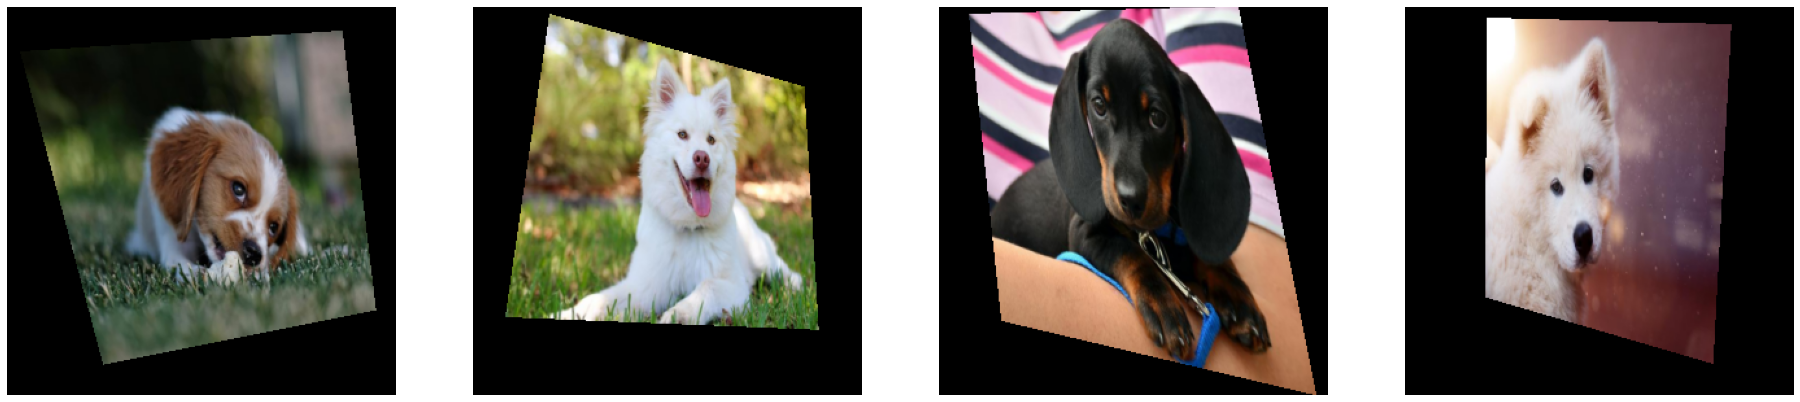

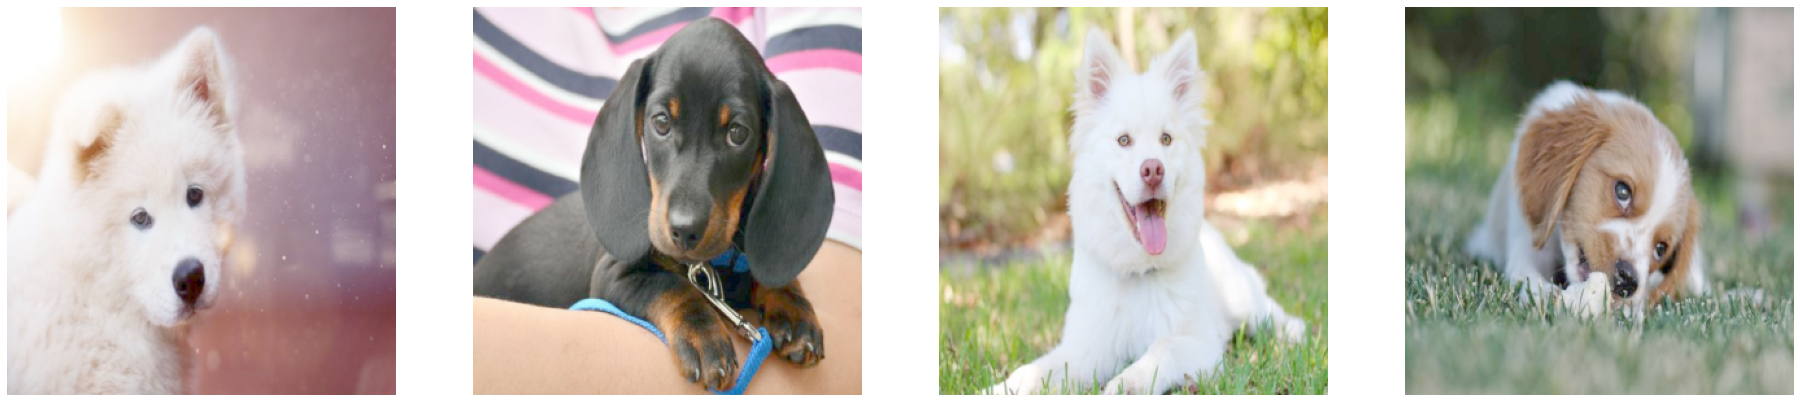

In [5]:
torch_function_pipe.build()

x, y = torch_function_pipe.run()
show_images(x)
show_images(y)

## Limitations of Python Operators
The pipelines that incorporate Python operators have to be constructed with `exec_async=False` and `exec_pipelined=False` specified. It is necessary to allow calling Python code from inside of DALI. Those options affetct the data pipeline performance.

As a result of Python threading model, Python operators cannot utilize more than one CPU core. 
Taking these factors into account, Python operators are very useful for testing, debugging or prototyping but are not considered to be a production level solution to extend DALI. 